# Model: Random Forest Regressor
This notebook documents our process of approaching the given regression task using a RandomForestRegressor. The following approaches are documented:
* paramter optimization using RandomizedSearchCV
* paramter optimization using Hyperopt
* each of the mentioned approaches is tried with K-Fold CrossValidation and TimeSeriesSplit CrossValidation

In [6]:
from sklearn.metrics import mean_squared_error
import data_preprocessing
from sklearn.ensemble import RandomForestRegressor
from hyperopt import hp, space_eval, tpe, fmin, Trials
from math import sqrt
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

In [2]:
# import preprocessed data
train, test = data_preprocessing.preprocess_data("Energy Consumption Dataset.csv")

In [3]:
# separate features from target variable
def split_x_y(df):
    y = df["Energy Consumption"]
    X = df.drop("Energy Consumption", axis=1)
    return X, y

X_train, y_train = split_x_y(train)
X_test, y_test = split_x_y(test)

## Using RandomizedSearchCV
First, we need to create a search grid / parameter distribution for RandomizedSearchCV to select from

In [25]:
param_dist = {
    'min_samples_leaf': uniform(),
    'min_samples_split': uniform(),
    'max_depth': randint(2, 18),
    'max_features': randint(1, 18),
    'ccp_alpha': uniform(),
    'max_leaf_nodes': randint(10, 100),
    'min_impurity_decrease': uniform(),
    'min_weight_fraction_leaf': uniform(0.01, 0.5),

    'n_estimators': randint(100, 500),
    'bootstrap': [True, False],
    'oob_score': [True, False], 
    'max_samples': uniform()
}

### Using K-Fold CrossVal

In [5]:
# Create the RF Regressor
reg = RandomForestRegressor(random_state=42)
# Create the RandomizedSearchCV instance
random_search = RandomizedSearchCV(reg,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=5,
                                   random_state=42,
                                   scoring="neg_mean_squared_error")

# perform the hyperparameter optimization
random_search.fit(X_train, y_train)

c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
230 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 402, in fit
    raise Valu

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001271CA77A90>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001271CA76E50>,
                                        'max_features': <scipy.stats._dis...
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001271CA76810>,
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001271C258C90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001271C259350>,
                                        'oob_score': [True, False]},
                   random_state=42, scoring='neg_mean_squared_error')

In [8]:
# inspect the model's performance
best_score = random_search.best_score_
rmse = sqrt(-best_score)
print("RMSE: ", rmse)
print("NRMSE: ", rmse / (y_test.max() - y_test.min()))

RMSE:  11334.54540420434
NRMSE:  0.16735884895319877


In [9]:
# inspect the tuned hyperparameters
best_params = random_search.best_params_
best_params

{'bootstrap': True,
 'ccp_alpha': 0.04771612769164879,
 'max_depth': 11,
 'max_features': 16,
 'max_leaf_nodes': 60,
 'max_samples': 0.7578461104643691,
 'min_impurity_decrease': 0.014393488629755868,
 'min_samples_leaf': 0.11607264050691624,
 'min_samples_split': 0.04600264202175275,
 'min_weight_fraction_leaf': 0.03036440115948507,
 'n_estimators': 337,
 'oob_score': False}

RMSE:  12126.06815997252
NRMSE:  0.17904598174958686


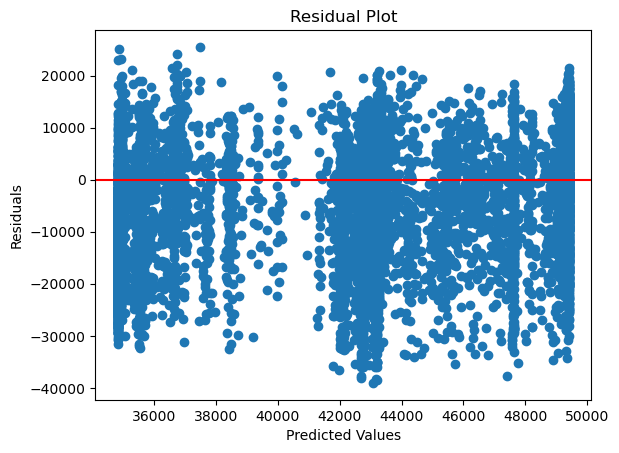

In [10]:
# Train the model on the whole dataset and predict unseen data to assess it's real performance
rf = RandomForestRegressor(**best_params, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)
print("NRMSE: ", rmse / (y_test.max() - y_test.min()))

plt.scatter(y_pred, y_test - y_pred)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Using TimeSeriesSplit

In [11]:
# Create TimeSeriesSplit instance
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# Create the RF Regressor
reg = RandomForestRegressor(random_state=42)
# Create the RandomizedSearchCV instance
random_search = RandomizedSearchCV(reg,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=tscv, # here, we pass TSCV instead of regular CV
                                   random_state=42,
                                   scoring="neg_mean_squared_error")

# perform the hyperparameter optimization
random_search.fit(X_train, y_train)

c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
230 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 402, in fit
    raise Valu

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001271CA77A90>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete...
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001271CA76810>,
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001271C258C90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001271C259350>,
                                        'oob_score': [True, False]},
                   random_state=42, scoring='neg_mean_squared_error')

In [13]:
# inspect the model's performance
best_score = random_search.best_score_
rmse = sqrt(-best_score)
print("RMSE: ", rmse)
print("NRMSE: ", rmse / (y_test.max() - y_test.min()))

RMSE:  11429.96106248341
NRMSE:  0.16876769722829355


In [14]:
# inspect the tuned hyperparameters
best_params = random_search.best_params_
best_params

{'bootstrap': True,
 'ccp_alpha': 0.04771612769164879,
 'max_depth': 11,
 'max_features': 16,
 'max_leaf_nodes': 60,
 'max_samples': 0.7578461104643691,
 'min_impurity_decrease': 0.014393488629755868,
 'min_samples_leaf': 0.11607264050691624,
 'min_samples_split': 0.04600264202175275,
 'min_weight_fraction_leaf': 0.03036440115948507,
 'n_estimators': 337,
 'oob_score': False}

RMSE:  12126.06815997252
NRMSE:  0.17904598174958686


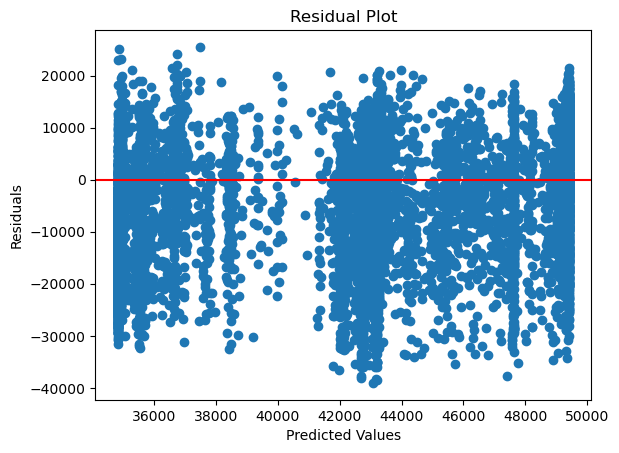

In [15]:
# Train the model on the whole dataset and predict unseen data to assess it's real performance
rf = RandomForestRegressor(**best_params, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)
print("NRMSE: ", rmse / (y_test.max() - y_test.min()))

plt.scatter(y_pred, y_test - y_pred)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()